<a href="https://colab.research.google.com/github/Chiebukar/Age-and-Gender-Prediction/blob/main/race_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Open with google colab for better view

# Get Dataset

In [ ]:
# upload kaggle key to get dataset
from google.colab import files
files.upload()

In [ ]:
# create new folder
!mkdir -p ~/.kaggle 

# copy kaggle file to folder
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download dataset
!kaggle datasets download -d aibloy/fairface

 97% 535M/550M [00:05<00:00, 116MB/s]
100% 550M/550M [00:05<00:00, 98.1MB/s]


In [ ]:
# unzip and remove zip files
!unzip \*.zip && rm *.zip

In [ ]:
# show file list
!ls -d $PWD/FairFace/*

/content/FairFace/train		    /content/FairFace/val
/content/FairFace/train_labels.csv  /content/FairFace/val_labels.csv


In [ ]:
# get data paths
train_data_path = '/content/FairFace/train_labels.csv'
val_data_path = '/content/FairFace/val_labels.csv'

In [ ]:
# install vggface model
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

In [ ]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import collections
import cv2
import os
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers import  Flatten, Dropout, Dense
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras import regularizers
from keras import applications as keras_applications
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from sklearn.metrics import confusion_matrix

In [ ]:
# read input data into dataframe
train_data = pd.read_csv(train_data_path)
val_data  = pd.read_csv(val_data_path)

In [ ]:
# preview training data
train_data.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


# Exploratory Data Analysis

In [ ]:
# show data columns
train_data.columns

Index(['file', 'age', 'gender', 'race', 'service_test'], dtype='object')

In [ ]:
# get relevant columns only
train_data = train_data[['file', 'race']]
val_data = val_data[['file', 'race']]

In [ ]:
# show dataframe
train_data.tail(3)

,file,race
86741,train/86742.jpg,Indian
86742,train/86743.jpg,Black
86743,train/86744.jpg,White


In [ ]:
# show lengths of input data
len(train_data), len(val_data)

(86744, 10954)

In [ ]:
# show data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86744 entries, 0 to 86743
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    86744 non-null  object
 1   race    86744 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [ ]:
# check for null values
train_data.isnull().sum()

file    0
race    0
dtype: int64

In [ ]:
# show  unique labels in target column
print('the unique race labels are : {}'.format(np.sort(train_data['race'].unique())))

the unique race labels are : ['Black' 'East Asian' 'Indian' 'Latino_Hispanic' 'Middle Eastern'
 'Southeast Asian' 'White']


In [ ]:
# show  labels count
race_count = pd.DataFrame(train_data['race'].value_counts()).rename(columns= {'race':'Num_values'})
race_count

,Num_values
White,16527
Latino_Hispanic,13367
Indian,12319
East Asian,12287
Black,12233
Southeast Asian,10795
Middle Eastern,9216


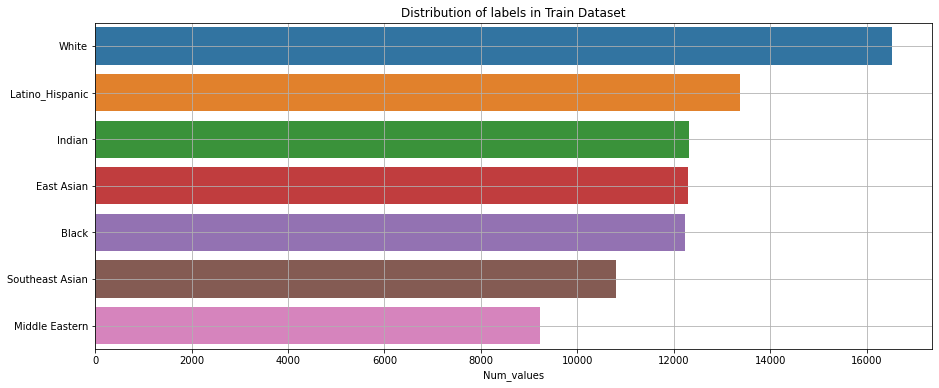

In [ ]:
# plot count of labels
plt.figure(figsize= (15,6))
sns.barplot(x= race_count['Num_values'], y= race_count.index.to_list())
plt.title('Distribution of labels in Train Dataset')
plt.grid(True)
plt.show()

In [ ]:
# display pieplot of label distribution.
pie_plot = go.Pie(labels= race_count.index.to_list(), values=race_count.values.flatten(), 
                  hole=0.3, text= race_count.index.to_list(),textposition= 'auto')
fig = go.Figure(data=[pie_plot])
fig.update_layout(title_text='Pie Plot of Race Distribution')
fig.show()

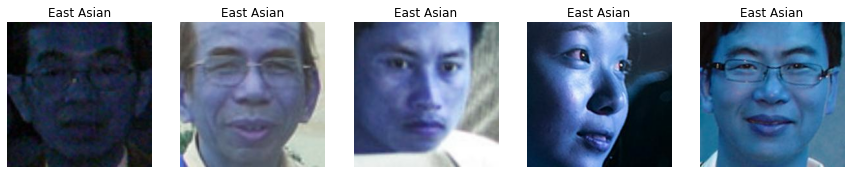

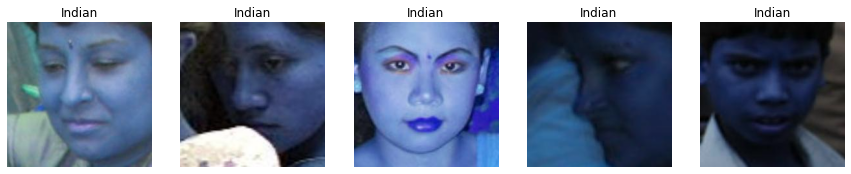

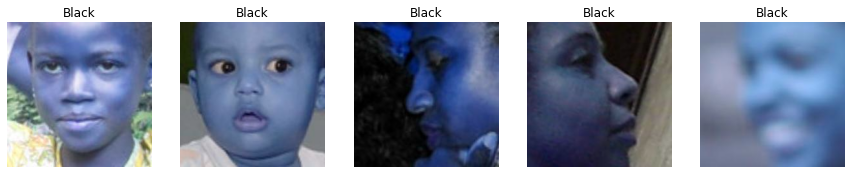

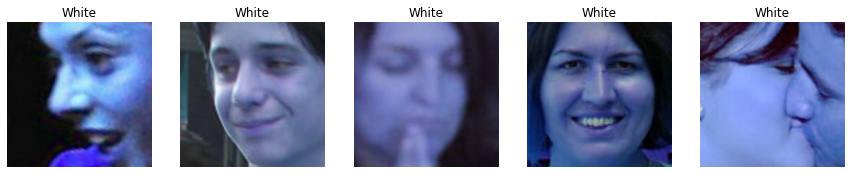

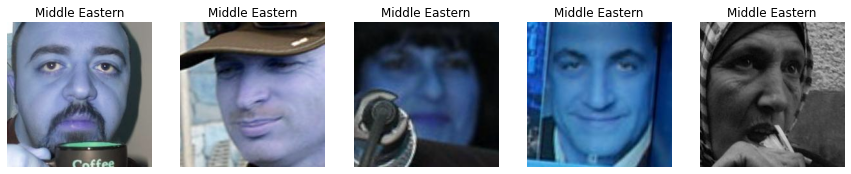

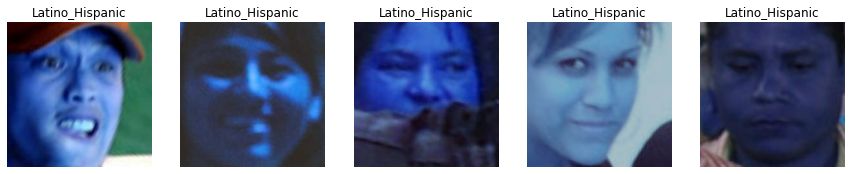

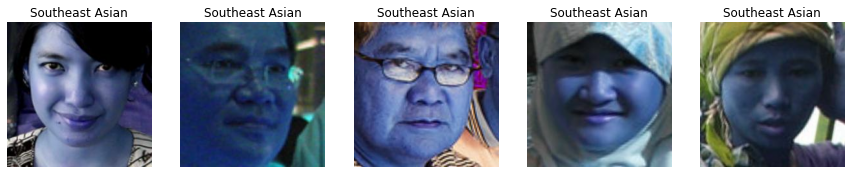

In [ ]:
# plot sample images
for i, label in enumerate(train_data['race'].unique()):
  class_series = train_data[train_data['race']== label]['file']
  values = class_series.values
  fig = plt.figure(figsize = (15,6))
  for j, file in enumerate(values[:5]):
    path = '/content/FairFace/' + file
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    fig.add_subplot(1,5, j+1)
    plt.imshow(img)
    plt.subplots_adjust(hspace=0.5)
    plt.axis(False)
    plt.title(label) 

# Data Preprocessing

In [ ]:
# merge East Asian and Southeast Asian classes as  Asian class
idx = train_data[(train_data['race'] == 'East Asian') | (train_data['race'] == 'Southeast Asian')].index
train_data.loc[idx, 'race'] = 'Asian'
 
idx = val_data[(val_data['race'] == 'East Asian') | (val_data['race'] == 'Southeast Asian')].index
val_data.loc[idx, 'race'] = 'Asian'

In [ ]:
# show unique classes
train_data.race.unique()

array(['Asian', 'Indian', 'Black', 'White', 'Middle Eastern',
       'Latino_Hispanic'], dtype=object)

In [ ]:
# get number of classes
NUM_CLASSES = len(train_data.race.unique())
NUM_CLASSES

6

In [ ]:
# show labels count
train_data.race.value_counts()

Asian              23082
White              16527
Latino_Hispanic    13367
Indian             12319
Black              12233
Middle Eastern      9216
Name: race, dtype: int64

In [ ]:
val_data.race.value_counts()

Asian              2965
White              2085
Latino_Hispanic    1623
Black              1556
Indian             1516
Middle Eastern     1209
Name: race, dtype: int64

In [ ]:
# split validation data  into train and validation sets
val_data, test_data = train_test_split(val_data, test_size= 0.5, random_state= 0, stratify= val_data['race'])

In [ ]:
# define  data generators
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, vertical_flip=True, rescale=1/.255)

val_datagen = ImageDataGenerator(1/.255)

test_datagen = ImageDataGenerator(1/.255)

In [ ]:
# define batch size
BATCH_SIZE = 128

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe= train_data, directory= '/content/FairFace/', 
                                              x_col = 'file', y_col='race', target_size=(224, 224),
                                              color_mode='rgb', class_mode='categorical', 
                                              batch_size=BATCH_SIZE, shuffle=True, seed=0)

val_gen = val_datagen.flow_from_dataframe(dataframe= val_data, directory= '/content/FairFace/', 
                                              x_col = 'file', y_col='race', target_size=(224, 224),
                                              color_mode='rgb', class_mode='categorical', 
                                              batch_size=BATCH_SIZE, shuffle=True, seed=0)

test_gen = test_datagen.flow_from_dataframe(dataframe= test_data, directory= '/content/FairFace/', 
                                              x_col = 'file', y_col='race', target_size=(224, 224),
                                              color_mode='rgb',class_mode='categorical', 
                                              batch_size=BATCH_SIZE, shuffle=True, seed=0)

Found 86744 validated image filenames belonging to 6 classes.
Found 5477 validated image filenames belonging to 6 classes.
Found 5477 validated image filenames belonging to 6 classes.


# Race  Classifier Model Building

In [ ]:
# initialize VGGFace model
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))
# vggface.summary()

In [ ]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(vggface.trainable_weights))

# freeze all but last 120 layers
for layer in vggface.layers[:-120]:
    layer.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(vggface.trainable_weights))

In [ ]:
# build model
model = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(NUM_CLASSES, activation='softmax')])

In [ ]:
# compile model
model.compile(optimizer = keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])

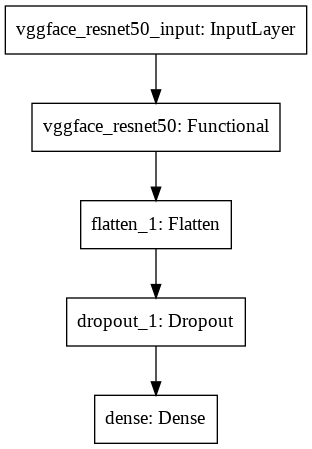

In [ ]:
# plot model
plot_model(model, 'race_model.png')

# Model Training

In [ ]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min', restore_best_weights= True)

checkpoint = ModelCheckpoint('race_model.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

In [ ]:
# define training steps
TRAIN_STEPS = len(train_data)//BATCH_SIZE
VAL_STEPS = len(val_data)//BATCH_SIZE

In [ ]:
# train model
history = model.fit(train_gen, steps_per_epoch= len(train_data)//BATCH_SIZE,
                           validation_data = val_gen,
                           validation_steps = len(val_data)//BATCH_SIZE,
                           epochs = 10, callbacks = [reduceLR, early_stopping, checkpoint])

Epoch 1/10
677/677 [==============================] - ETA: 0s - loss: 1.5761 - acc: 0.4157

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



677/677 [==============================] - 1068s 1s/step - loss: 1.5757 - acc: 0.4158 - val_loss: 1.0118 - val_acc: 0.6337

Epoch 00001: val_loss improved from inf to 1.01175, saving model to emotion_model.weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/10
677/677 [==============================] - 996s 1s/step - loss: 1.0703 - acc: 0.5882 - val_loss: 0.8913 - val_acc: 0.6758

Epoch 00002: val_loss improved from 1.01175 to 0.89133, saving model to emotion_model.weights.hdf5
Epoch 3/10
677/677 [==============================] - 998s 1s/step - loss: 0.9802 - acc: 0.6252 - val_loss: 0.9020 - val_acc: 0.6546

Epoch 00003: val_loss did not improve from 0.89133
Epoch 4/10
677/677 [==============================] - 1000s 1s/step - loss: 0.9344 - acc: 0.6442 - val_loss: 0.8910 - val_acc: 0.6637

Epoch 00004: val_loss improved from 0.89133 to 0.89105, saving model to emotion_model.weights.hdf5
Epoch 5/10
677/677 [==============================] - 1007s 1s/step - loss: 0.8976 - acc: 0.6582 - val_loss: 0.9598 - val_acc: 0.6549

Epoch 00005: val_loss did not improve from 0.89105
Epoch 6/10
677/677 [==============================] - 999s 1s/step - loss: 0.8728 - acc: 0.6704 - val_loss: 0.9241 - val_acc: 0.6596

Epoch 00006: ReduceLROnPlate

In [ ]:
# read training history into dataframe
history_df = pd.DataFrame(history.history)

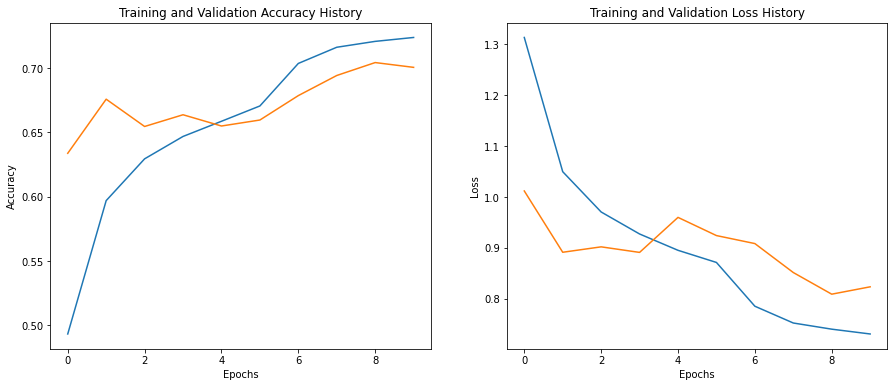

In [ ]:
# display training and validation history

# display history of accurracy
plt.figure(figsize= (15,6))
plt.subplot(1,2,1)
plt.plot(history_df['acc'])
plt.plot(history_df['val_acc'])
# history_df[['acc', 'val_acc']]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')

# display history of accurracy
plt.subplot(1,2,2)
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
# history_df[['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')

plt.show()

In [ ]:
# # load best weights to model
# model.load_weights('race_model.weights.hdf5')

In [ ]:
# #  save model 
# model.save('race_model.h5')

# Model Testing and Evaluation

In [ ]:
# evaluate model on validation set
print('Model performance on the validation set: '.format(model.evaluate(val_gen)))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



43/43 [==============================] - 19s 437ms/step - loss: 0.8093 - acc: 0.7044
Model performance on the validation set: 


In [ ]:
# evaluate model on test test
print('Model performance on the validation set: '.format(model.evaluate(test_gen)))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



43/43 [==============================] - 16s 365ms/step - loss: 0.8069 - acc: 0.7082
Model performance on the validation set: 


In [ ]:
# get test data prediction
y_predicted = model.predict_generator(test_gen)
y_predicted = np.argmax(y_predicted, axis=1)

In [ ]:
# get test data true labels
y_truth = [] 
for i in range(VAL_STEPS + 1):
  y_truth.extend(test_gen[i][1])

y_truth = np.argmax(y_truth, axis=1)

In [ ]:
# get labels
labels = [label for label in test_gen.class_indices.keys()]
labels

['Asian', 'Black', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'White']

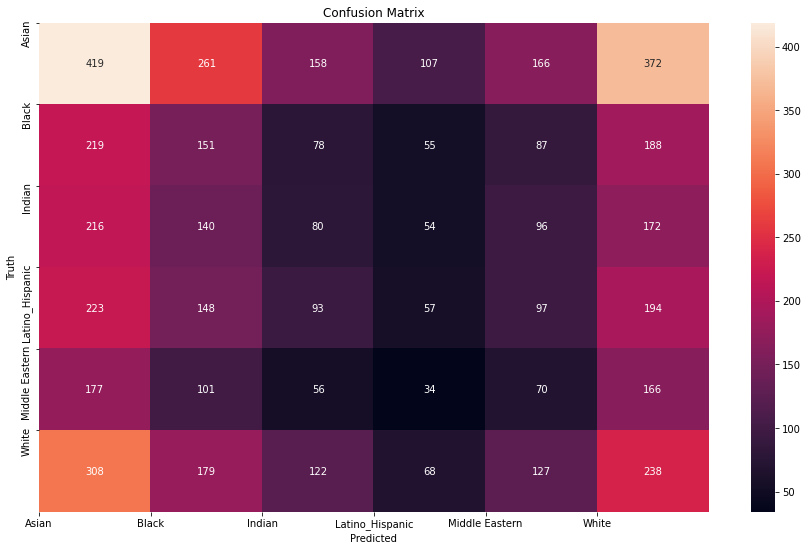

In [ ]:
# display confusion matrix
plt.figure(figsize= (15, 9))
cm = confusion_matrix(y_truth, y_predicted)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.show()

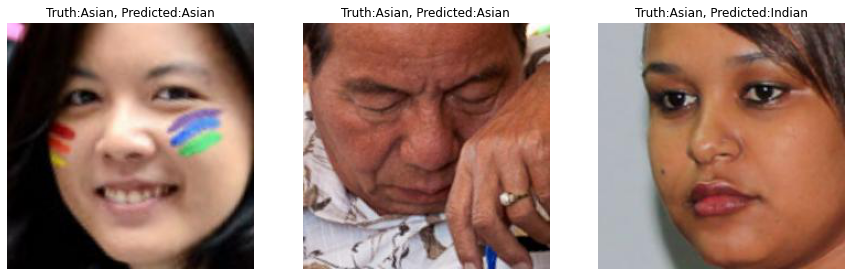

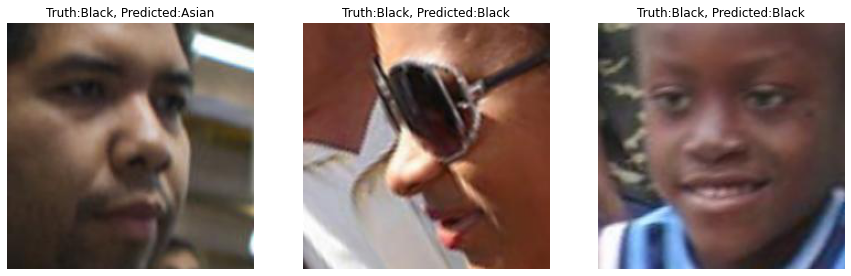

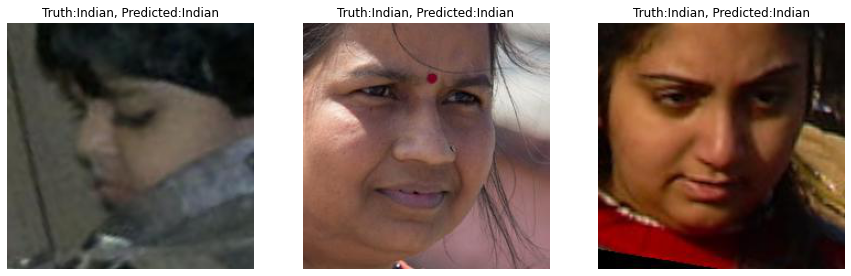

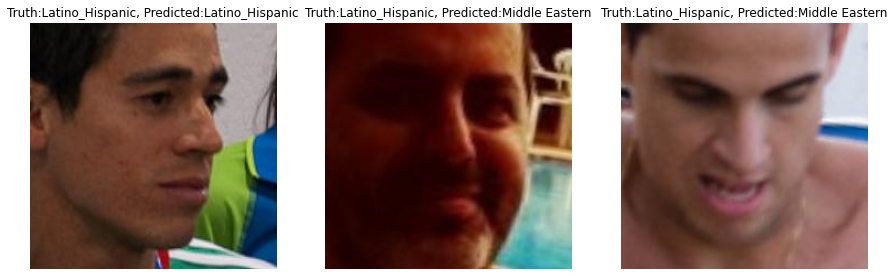

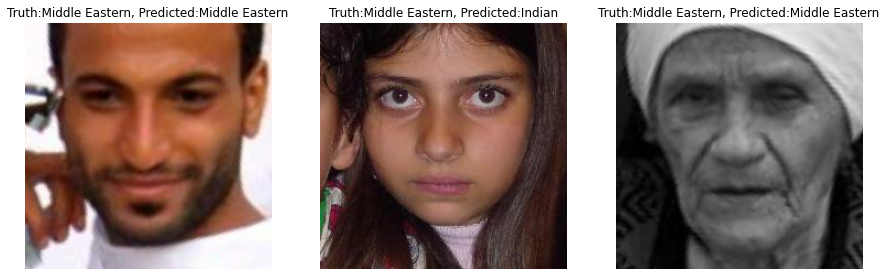

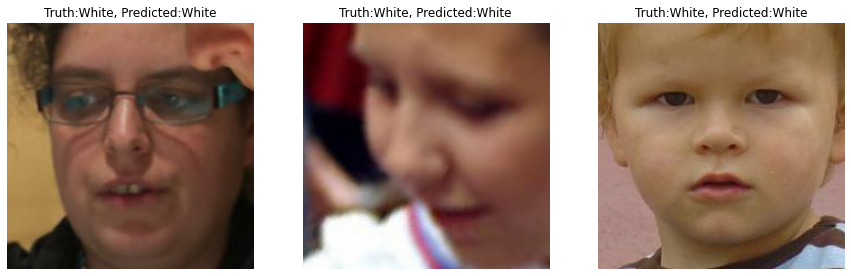

In [ ]:
# plot sample images with true and predicted labels
for i, label in enumerate(labels):
  class_series = val_data[val_data['race']== label]['file']
  values = class_series.values
  fig = plt.figure(figsize = (15,6))
  for j, filename in enumerate(values[:3]):
    path = '/content/FairFace/' + filename
    img = image.load_img(path, target_size = (224,224))
    test_img = image.img_to_array(img)
    test_img = np.expand_dims(test_img, axis = 0)
    predicted  = np.argmax(model.predict(test_img), axis=1)
    predicted_label = labels[int(predicted)]
    fig.add_subplot(1,3, j+1)
    plt.imshow(img)
    plt.subplots_adjust(hspace=0.5)
    plt.axis(False)
    plt.title('Truth:{0}, Predicted:{1}'.format(label, predicted_label))
plt.show()